In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
from IPython.display import Audio
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Bidirectional, GRU, BatchNormalization, LeakyReLU
from keras.utils import to_categorical
import os
import math
import json
import random

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Data/genres_original'
JSON_PATH = '/content/drive/MyDrive/Data/myjson.json'
SAMPLE_RATE = sr =  22050
DURATION = 30 #measured in seconds 
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=4084, hop_length=1024, num_segments=10):
    #dictionary to store data
    data = {
        'mapping' : [],
        'mfcc' : [],
        'labels' : []
    }
    
    count = 0 # To keep track of our progress
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments) 
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
    
    #Loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        #ensure that we're not at the root level
        if dirpath not in dataset_path:

            #save the semantic label
            dirpath_components = dirpath.split('/')
            semantic_label = dirpath_components[-1]
            data['mapping'].append(semantic_label)
            print('\nProcessing {}'.format(semantic_label))
            
            #process files for a specific genre 
            for f in filenames:
                if f.endswith('.wav') and f != 'jazz.00054.wav': # Since file jazz.00054.wav is an empty file
                    
                    file_path = os.path.join(dirpath,f)
                    
                    #loading the audio file 
                    # we are using the soundfile library since it is faster than librosa
                    signal, sr = sf.read(file_path) # len(signal) = 661794  # sr is 22050 by default 
                    #print(signal,sr)
                    #process segments extracting mfcc and storing data
                    for s in range(num_segments): 
                        # Since num_segments is defined as 5. Every 30 sec file is divided into 5 segments of length 6sec 
                        # Start sample would keep track of the index of the first element of each 6 second batch
                        # finish sample would keep track of the index of the last element of each 6 second batch
                        # And then with the help of python's slice functionality we will extract that 6 second batch from every 30 sec signal
                        start_sample = num_samples_per_segment * s   
                        finish_sample = num_samples_per_segment + start_sample
                        
                        # Next, we will pass each segment in order to extract MFCC. The parameter n_mfcc defines the number of mfcc 
                        # we need to extract, Usually n_mfcc is set b/w 13 to 40. The other parameters n_fft and hop length are 
                        # indivisual topics of discussion. Will be discussed in later Notbooks. 
                        mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample],
                                                   sr = sr,
                                                   n_fft = n_fft,
                                                   n_mfcc = n_mfcc,
                                                   hop_length = hop_length)

                        mfcc = mfcc.T
                        # store mfcc for segment if it has the expected length
                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            print(mfcc.shape)
                            data['mfcc'].append(mfcc.tolist())
                            data['labels'].append(i)
                            print('Processing {}, segment:{}'.format(file_path, s))
                            count += 1
                            print(count)
    with open(json_path, 'w') as fp:
        json.dump(data, fp, indent=4)

In [ ]:
# Let's run the above function 
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

In [ ]:
# loading the saved Json file
def load_data(path):
    with open(path, 'r') as fp:
        data = json.load(fp)
        
    #Convert lists into numpy arrays
    inputs = data['mfcc']
    targets = data['labels'] 
    return np.array(inputs), np.array(targets)

In [ ]:
inputs, targets = load_data("/content/drive/MyDrive/Data/myjson.json")

In [ ]:
print(inputs)

In [ ]:
inputs.shape

(9979, 65, 13)

In [ ]:
np.unique(targets, return_counts=True)

(array([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11]),
 array([1000,  999,  990, 1000, 1000, 1000,  990, 1000, 1000, 1000]))

In [ ]:
# Converting labels from 15-24 to 0-9
v = min(np.unique(targets))
for i in range(len(targets)):
    if targets[i] == v:
        targets[i] = 0
    else:
        new = targets[i] - v
        targets[i] = new

In [ ]:
np.unique(targets, return_counts=True)

(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10]),
 array([1000,  999,  990, 1000, 1000, 1000,  990, 1000, 1000, 1000]))

In [ ]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.25)

In [ ]:
# Adding Noise 
for i in range(inputs_train.shape[0]):
    s = np.random.rand(inputs_train.shape[1], inputs_train.shape[2])
    inputs_train[i] = inputs_train[i] + s


In [ ]:
model = Sequential()

model.add(GRU(100, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
model.add(GRU(500, return_sequences=True))
model.add(GRU(1000))
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(100))
model.add(LeakyReLU())
model.add(Dense(11, 'softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 65, 100)           34500     
                                                                 
 gru_1 (GRU)                 (None, 65, 500)           903000    
                                                                 
 gru_2 (GRU)                 (None, 1000)              4506000   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1000)              0         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                        

In [ ]:
history = model.fit(inputs_train, targets_train,
          validation_data=(inputs_test, targets_test),
          epochs = 50,
          batch_size=100)

Epoch 1/50
75/75 [==============================] - 442s 6s/step - loss: 1.6663 - accuracy: 0.4538 - val_loss: 1.6493 - val_accuracy: 0.4729
Epoch 2/50
75/75 [==============================] - 427s 6s/step - loss: 1.1282 - accuracy: 0.6069 - val_loss: 1.3823 - val_accuracy: 0.5347
Epoch 3/50
75/75 [==============================] - 426s 6s/step - loss: 0.8975 - accuracy: 0.6823 - val_loss: 1.0308 - val_accuracy: 0.6585
Epoch 4/50
75/75 [==============================] - 429s 6s/step - loss: 0.7570 - accuracy: 0.7296 - val_loss: 0.9447 - val_accuracy: 0.6613
Epoch 5/50
75/75 [==============================] - 431s 6s/step - loss: 0.6408 - accuracy: 0.7694 - val_loss: 0.7888 - val_accuracy: 0.7138
Epoch 6/50
75/75 [==============================] - 431s 6s/step - loss: 0.5357 - accuracy: 0.8152 - val_loss: 0.7990 - val_accuracy: 0.7222
Epoch 7/50
75/75 [==============================] - 437s 6s/step - loss: 0.4413 - accuracy: 0.8406 - val_loss: 0.7234 - val_accuracy: 0.7619
Epoch 8/50
75

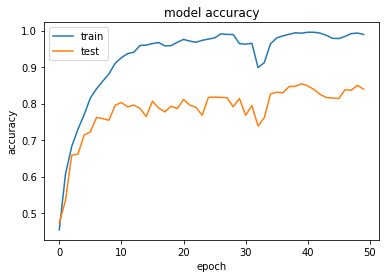

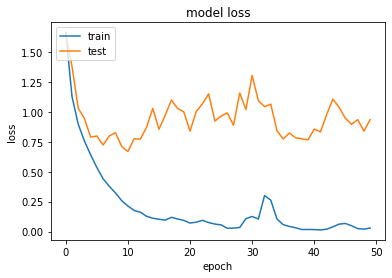

In [ ]:
print(history)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()